In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from geopandas import sjoin
from shapely.geometry import Point

Setting up the Coordinate Reference Systems up front in the necessary format.

In [2]:
# Globals
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# Attention: export the geo data (lat/lng and shapefiles) with the same Coordinate Reference System!
### Currently for this IPython (and maybe in future), we are going with `CGS_WGS_1984`.

### How to export:

- In ArcGIS -> Analysis -> Tools: 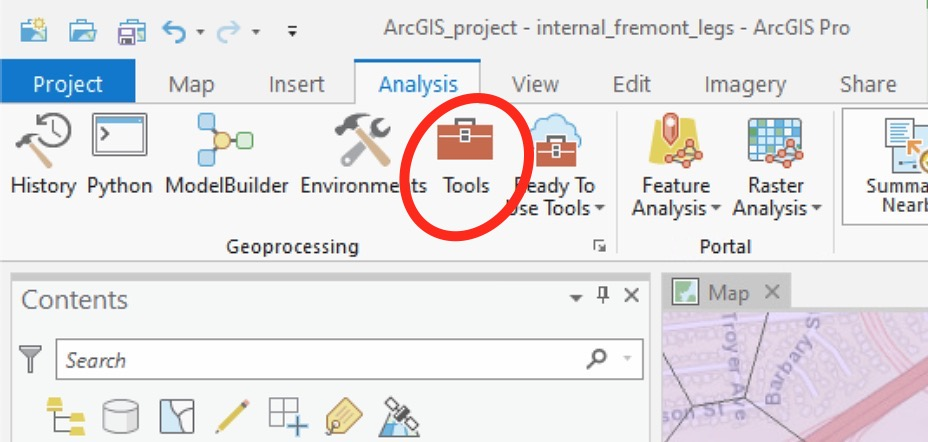

- On the right side, pick the data and click on folder icon: 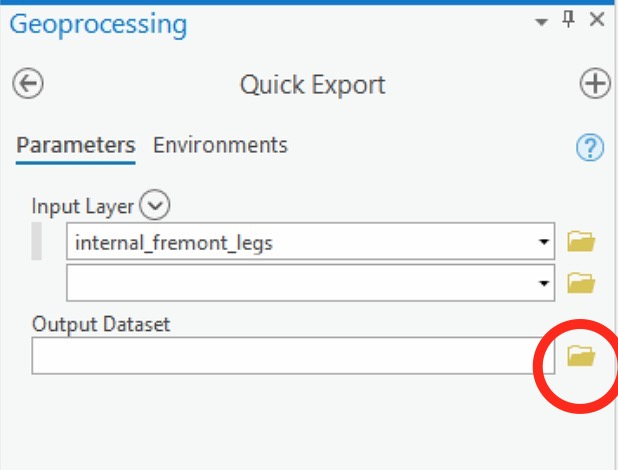

- Pick `CGS_WGS_1984` Coord. system: 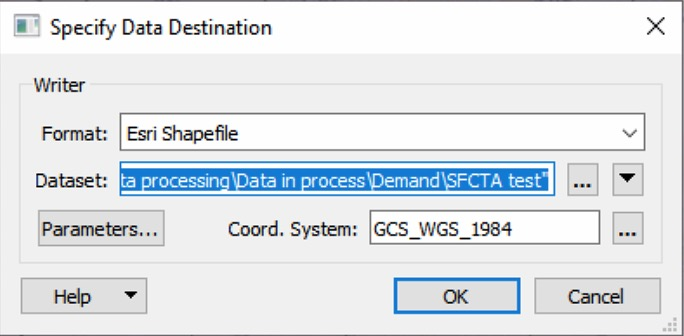


In [3]:
# Paths
data_collection = "/Users/michaltakac/Dropbox/Data Collection"
data_in_process = data_collection + "/Data Processing/Data in process"

arcgis_project = "/Users/michaltakac/Dropbox/Data Collection/ArcGIS"
int_centroid_zones = data_in_process + "/Demand/SFCTA test/InternalCentroidZones.shp"

int_legs= "/Users/michaltakac/Dropbox/Data Collection/Raw data/SFCTA demand data/internal_fremont_legs.csv"

In [4]:
# Load internal centroid zones from shapefile
icz = GeoDataFrame.from_file(int_centroid_zones)
icz.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,CentroidID,geometry
0,0,2,3732.741316,8.192720e+05,21,"POLYGON Z ((-121.92829 37.49921 0.00000, -121...."
1,1,3,9042.119570,4.329841e+06,26,"POLYGON Z ((-121.95631 37.49854 0.00000, -121...."
2,2,4,6766.028824,2.260875e+06,1,"POLYGON Z ((-121.95809 37.50038 0.00000, -121...."
3,3,5,2672.089121,4.399604e+05,29,"POLYGON Z ((-121.94043 37.50354 0.00000, -121...."
4,4,6,6126.178508,1.361209e+06,25,"POLYGON Z ((-121.93679 37.49704 0.00000, -121...."


In [5]:
int_data = pd.read_csv(int_legs)

# test if loaded...
int_data.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432


In [6]:
# Process XY coordinates data as Point geometry for start nodes
int_start_nodes = [Point(xy) for xy in zip(int_data.start_node_lng, int_data.start_node_lat)]

In [7]:
# Process XY coordinates data as Point geometry for end nodes
int_end_nodes = [Point(xy) for xy in zip(int_data.end_node_lng, int_data.end_node_lat)]

In [8]:
# Create GeoDataFrame from start points
int_start_points = GeoDataFrame(pd.read_csv(int_legs), crs=crs_degree, geometry=int_start_nodes)
# just checking how the GeoDataFrame looks...
int_start_points.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937)
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764)
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287)
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237)
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598)


In [9]:
# Create GeoDataFrame from end points
int_end_points = GeoDataFrame(pd.read_csv(int_legs), crs=crs_degree, geometry=int_end_nodes)
# just checking how the GeoDataFrame looks...
int_end_points.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.93948 37.50078)
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94508 37.51287)
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94493 37.51764)
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.92959 37.49598)
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.95432 37.50237)


...okay, so we have geometry as `shapely.Point`s

Here we reuse the code from "Spatial Code Primer 2" (`In [9]`) for defining function that converts Voronoi output to a shapefile (`.shp`):


In [10]:
# Load internal fremont legs from shapefile
int_legs_shp = GeoDataFrame.from_file(data_in_process + '/Demand/SFCTA test/internal_fremont_legs.shp')
int_legs_shp.head()

,OBJECTID,leg_id,start_time,start_node,start_no00,end_node_l,end_node00,geometry
0,1,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937)
1,2,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764)
2,3,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287)
3,4,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237)
4,5,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598)


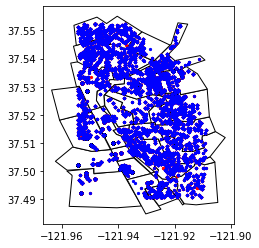

In [11]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

icz.plot(ax=ax, color='white', edgecolor='black')
int_start_points.plot(ax=ax, marker='o', color='red', markersize=5)
int_end_points.plot(ax=ax, marker='o', color='blue', markersize=5)

plt.show();

red color = start nodes, blue color = end nodes

In [12]:
# Spatial join (start nodes)
# docs: http://geopandas.org/mergingdata.html
int_int_start_nodes_OD = gpd.sjoin(int_start_points, icz, how='left', op='within')
# Some columns had stange names...
int_int_start_nodes_OD.rename(
    columns={
        "start_node": "start_node_lat",
        "start_no00": "start_node_lng",
        "end_node_l": "end_node_lat",
        "end_node00": "end_node_lng",
        "CentroidID": "CentroidID_O"
    },
    inplace=True
)
for column in ['index_left', 'index_right', 'OBJECTID']:
    try:
        int_int_start_nodes_OD.drop(column, axis=1, inplace=True)
    except KeyError:
        # ignore if there are no index columns
        pass
    
int_int_start_nodes_OD.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry,FID,Shape_Leng,Shape_Area,CentroidID_O
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937),16,6270.634124,2.379123e+06,2
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764),15,5539.626488,1.167626e+06,30
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287),15,5539.626488,1.167626e+06,30
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237),2,6766.028824,2.260875e+06,1
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598),4,6126.178508,1.361209e+06,25


In [13]:
# Spatial join (end nodes)
# docs: http://geopandas.org/mergingdata.html
int_int_end_nodes_OD = gpd.sjoin(int_end_points, icz, how='left', op='within')
int_int_end_nodes_OD.rename(
    columns={
        "CentroidID": "CentroidID_D"
    },
    inplace=True
)

for column in ['index_left', 'index_right', 'OBJECTID']:
    try:
        int_int_end_nodes_OD.drop(column, axis=1, inplace=True)
    except KeyError:
        # ignore if there are no index columns
        pass
    
int_int_end_nodes_OD.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry,FID,Shape_Leng,Shape_Area,CentroidID_D
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.93948 37.50078),2,6766.028824,2.260875e+06,1
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94508 37.51287),15,5539.626488,1.167626e+06,30
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94493 37.51764),15,5539.626488,1.167626e+06,30
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.92959 37.49598),4,6126.178508,1.361209e+06,25
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.95432 37.50237),2,6766.028824,2.260875e+06,1


In [14]:
int_int_OD = None
int_int_OD = int_int_start_nodes_OD.combine_first(int_int_end_nodes_OD)
# Make it look like it was generated from ArcGIS (has OBJECTID index starting from 1)
int_int_OD['OBJECTID'] = int_int_OD.index + 1
int_int_OD.head()

,CentroidID_D,CentroidID_O,FID,Shape_Area,Shape_Leng,end_node_lat,end_node_lng,geometry,leg_id,start_node_lat,start_node_lng,start_time,OBJECTID
0,1,2,16,2.379123e+06,6270.634124,37.50078,-121.93948,POINT (-121.94962 37.50937),87585773,37.50937,-121.94962,2000-01-01 22:39:00 +0800,1
1,30,30,15,1.167626e+06,5539.626488,37.51287,-121.94508,POINT (-121.94493 37.51764),87663883,37.51764,-121.94493,2000-01-01 22:52:00 +0800,2
2,30,30,15,1.167626e+06,5539.626488,37.51764,-121.94493,POINT (-121.94508 37.51287),87663885,37.51287,-121.94508,2000-01-02 00:29:00 +0800,3
3,25,1,2,2.260875e+06,6766.028824,37.49598,-121.92959,POINT (-121.95432 37.50237),87771074,37.50237,-121.95432,2000-01-01 22:35:00 +0800,4
4,1,25,4,1.361209e+06,6126.178508,37.50237,-121.95432,POINT (-121.92959 37.49598),87771078,37.49598,-121.92959,2000-01-02 02:48:00 +0800,5


In [15]:
pd.DataFrame.to_csv(int_int_OD,
    "int_int_OD.csv",
    encoding='utf8',
    index=False,
    columns=["OBJECTID", "leg_id","start_time","start_node_lat","start_node_lng","end_node_lat","end_node_lng","CentroidID_O","CentroidID_D"]
)

### Check if dataset generated with python matches the one from ArcGIS

In [16]:
int_int_OD_from_arcgis = pd.read_csv(data_collection + "/Demand Data/OD matrix/int_int_OD.csv")

In [17]:
int_int_OD_generated_with_py = pd.read_csv("int_int_OD.csv")

In [18]:
# Test
from pandas._testing import assert_frame_equal

try:
    assert_frame_equal(int_int_OD_from_arcgis, int_int_OD_generated_with_py)
    print("Success! Generated OD from Python (without arcpy) is the same as the one generated with arcpy.")
except AssertionError:
    print("Error! Generated OD from Python (without arcpy) is different than the one generated with arcpy!")

Success! Generated OD from Python (without arcpy) is the same as the one generated with arcpy.


OD clustering

In [19]:
from dateutil import tz
from datetime import datetime, timedelta
import pytz
from pytz import timezone

local_tz = timezone('US/Pacific')

def cluster_col_15min(df, outputname):
    df['dt'] = pd.to_datetime(df['start_time'])
    dt_15=[]
    for dt in df['dt']:
        #local_dt = dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
        dt_15.append(dt.replace(minute=int(dt.minute/15)*15,second = 0).replace(tzinfo=pytz.utc).astimezone(local_tz))

    df['dt_15'] = dt_15
    start_end = pd.pivot_table(df, index=['CentroidID_O','CentroidID_D'], columns = ['dt_15'], values=['OBJECTID'],
                         aggfunc={'OBJECTID':'count'}, fill_value = 0).rename(columns={'OBJECTID':'count'})
    start_end.to_csv(outputname)
    return start_end

In [20]:
cluster_col_15min(int_int_OD_generated_with_py, 'int_int_OD_col_15.csv')
cluster_OD_15min_int_int = pd.read_csv('int_int_OD_col_15.csv')

In [21]:
cluster_OD_15min_int_int_ref = pd.read_csv(data_collection + "/Demand Data/OD matrix/int_int_OD_col_15.csv")

In [22]:
# Test equality of clustered OD matrix
try:
    assert_frame_equal(cluster_OD_15min_int_int, cluster_OD_15min_int_int_ref)
    print("Success! Clustered OD matrix is the same as the reference.")
except AssertionError:
    print("Error! Clustered OD matrix is different than the reference!")

Success! Clustered OD matrix is the same as the reference.
